In [ ]:
#!/usr/bin/env python3
import argparse
import os
import matplotlib.pyplot as plt
import numpy as np
# from datetime import datetime
# from zoneinfo import ZoneInfo

from typing import Union, LiteralString, List
import pandas as pd

FileName = Union[LiteralString, str]
DEBUG: bool = False
VERBOSE: bool = False

In [95]:
class ExtractClusterData:

    def __init__(
                self, 
                 data: Union[pd.DataFrame, FileName], 
                 is_offline: bool = True,
                 perform_smoothen: bool = False
                 ) -> None:
        self.is_offline = is_offline

        # Create Panda Frame
        self.data = self.create_panda_dataframe(data)

        # Start and End indices
        self.start: int = 0
        self.end: int = self.data.size

        # Plot indices
        self.i = 0

        self.define_col_headers()    
    
    def define_col_headers(self) -> None:
        
        # For each column in the data frame
        for c in self.data.columns:

            # Create a class attribute and assign the column
            # NOTE: The .strip() method removes leading and trailing
            # whitespace.
            # NOTE: The .replace(' ', '_') replaces inner spaces with
            # underscores
            self.__setattr__(c.strip().replace(' ', '_'), self.data[c])

        # Prints all the keys
        if VERBOSE: print(self.__dict__.keys())  

    def smoothen() -> None:
        pass
    
    def _get_time_domain_fig(
                            self,
                            i, 
                            start: int, 
                            end: int, 
                            y: pd.DataFrame
                            ) -> plt.Figure:

        fig = plt.figure(i)

        # TODO: Can this be more generalizable and 
        # not hardcoded?
        plt.plot(self.timestamp[start:end], y[start:end])
        return fig
    

    def get_time_domain_figs(self) -> List[plt.Figure]:

        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        cluster_vars: dict[int, List[pd.DataFrame]] = \
            {
             1: [self.x_c_des, self.x_c],
             2: [self.y_c_des, self.y_c],
             3: [self.t_c_des, self.t_c],
             4: [self.p_des, self.p],
             5: [self.q_des, self.q],
             6: [self.B_des, self.B],
             }
        
        # Initialize empty list of 6 length
        figs: list = [None] * len(cluster_vars.keys())
        if DEBUG: print(len(figs))

        for k, list_values in cluster_vars.items():
            if DEBUG: print(k)
            for v in list_values:
                figs[k - 1] = \
                    self._get_time_domain_fig(
                    k,
                    self.start,
                    self.end,
                    v
                    )
        return figs
           
    def get_phase_portrait(
                           self,
                           ind: int,
                           start: int,
                           end: int
                           ) -> plt.Figure:
        
        fig = plt.figure(ind)
        plt.plot(self.x_c_des[start:end], self.y_c_des[start:end])
        plt.plot(self.x_c[start:end], self.y_c[start:end])
        return fig



    @staticmethod
    def create_panda_dataframe(data) -> pd.DataFrame:
        
        # Get datatype
        typ = type(data)

        # TODO: Check which type of string
        if typ == str or typ == LiteralString:
            return pd.read_csv(data)
        elif typ == pd.DataFrame:
            return data           

0
1
2
3
4
5


/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_28150/1041610448.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs[f].show()
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_28150/1041610448.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  phase_portrait.show()


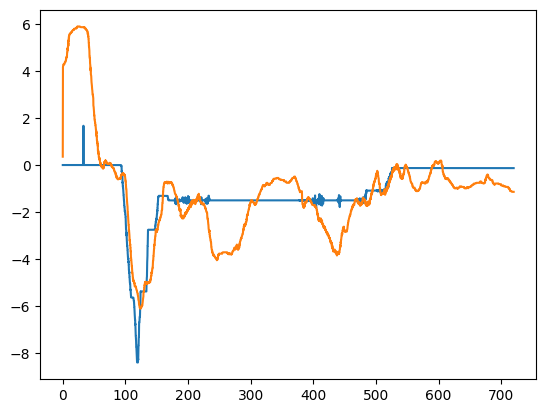

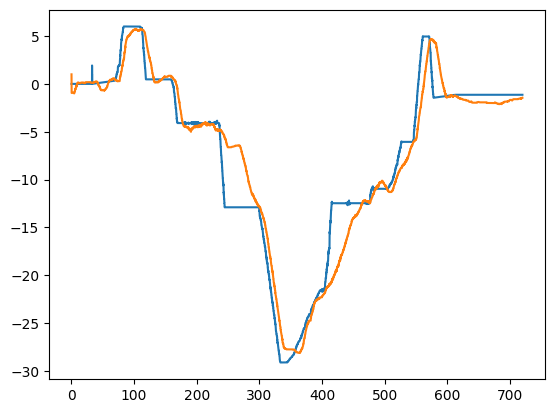

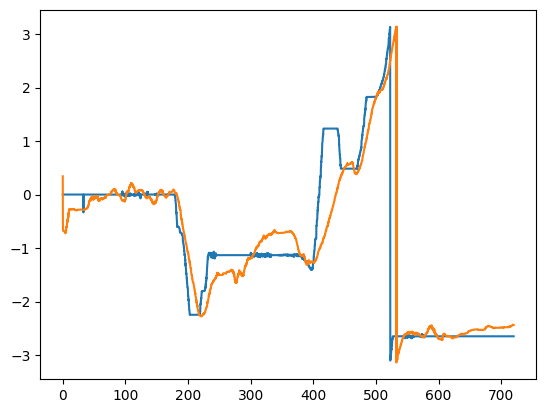

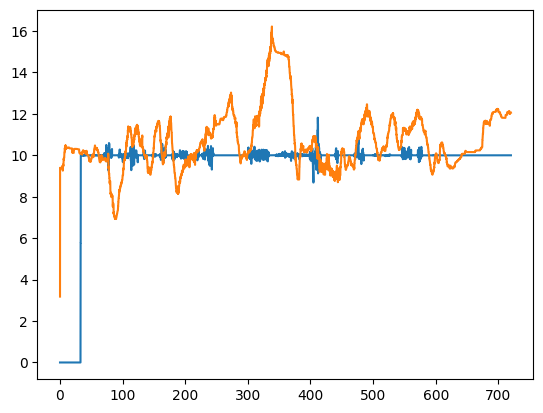

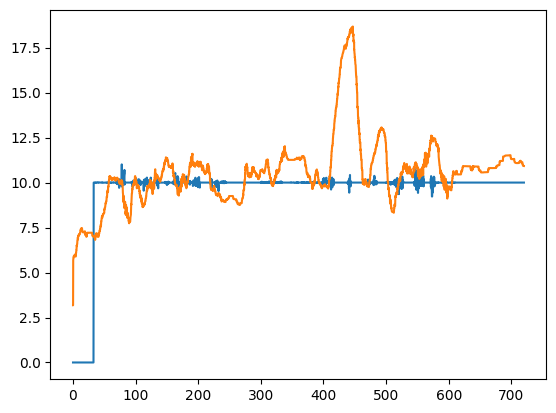

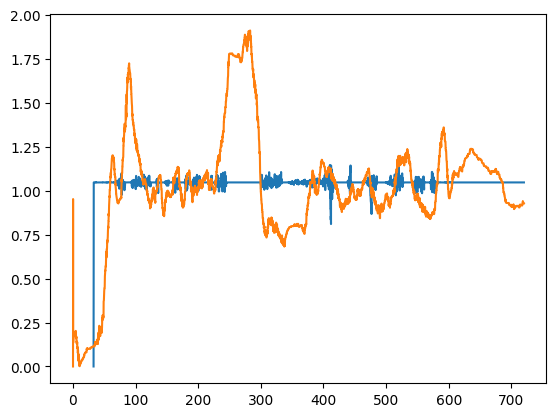

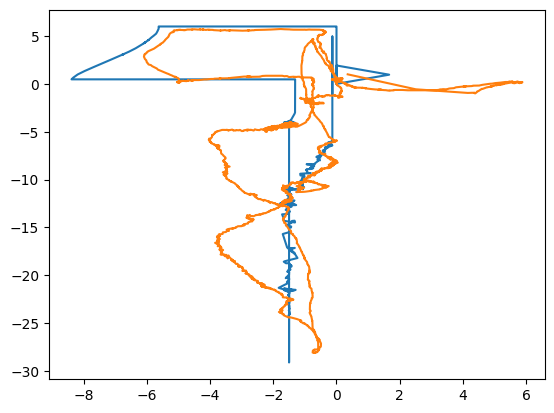

In [ ]:
def main2():
    
    grapher: ExtractClusterData = ExtractClusterData(
        "TestData_with_Timestamp.csv",
    )

    # TODO: Make this more customizeable
    # TODO: Identify time sections that are relevant
    grapher.end = 7200

    # Plot time domain graphs
    figs: List[plt.Figure] = grapher.get_time_domain_figs()
    for f in range(len(figs)):
        print(f)
        figs[f].show()

    # Plot phase portrait
    phase_portrait: plt.Figure = \
                            grapher.get_phase_portrait(
                                                      ind=7,
                                                      start=grapher.start,
                                                      end=grapher.end
                                                      )
    phase_portrait.show()


    # TODO: Insert labels and other options inside each plotting method
    # TODO: Insert titles and labels... in class or in main code (reading from YAML)



if __name__ == "__main__":
    main2()

In [53]:
# Testing Sections

grapher: ExtractClusterData = ExtractClusterData(
    "TestData_with_Timestamp.csv",
)

# print(grapher.data)

# d = grapher.data
# cols = d.columns
# # print(cols[0])

# grapher.__setattr__(cols[0], grapher.data[cols[0]])
# print(grapher.timestamp)
# # d[' t_des_3']


dict_keys(['is_offline', 'data', 'start', 'end', 'i', 'timestamp', 'datetime', 'x_1', 'y_1', 't_1', 'x_2', 'y_2', 't_2', 'x_3', 'y_3', 't_3', 'x_des_1', 'y_des_1', 't_des_1', 'x_des_2', 'y_des_2', 't_des_2', 'x_des_3', 'y_des_3', 't_des_3', 'x_c', 'y_c', 't_c', 'phi1', 'phi2', 'phi3', 'p', 'q', 'B', 'x_c_des', 'y_c_des', 't_c_des', 'phi1_des', 'phi2_des', 'phi3_des', 'p_des', 'q_des', 'B_des'])


In [60]:
grapher.__dict__.keys()



dict_keys(['is_offline', 'data', 'start', 'end', 'i', 'timestamp', 'datetime', 'x_1', 'y_1', 't_1', 'x_2', 'y_2', 't_2', 'x_3', 'y_3', 't_3', 'x_des_1', 'y_des_1', 't_des_1', 'x_des_2', 'y_des_2', 't_des_2', 'x_des_3', 'y_des_3', 't_des_3', 'x_c', 'y_c', 't_c', 'phi1', 'phi2', 'phi3', 'p', 'q', 'B', 'x_c_des', 'y_c_des', 't_c_des', 'phi1_des', 'phi2_des', 'phi3_des', 'p_des', 'q_des', 'B_des'])